# Introduction

This is an exploration of the biggest Pokémon Trading Card Game (PTCG) Pocket tournament to date, with over 2,800 participants and a $10,000 prize pool.

PCTG Pocket decks are comprised of 20 cards with a maximum of 2 of any card allowed. Decks are most often centered around pairs or trios of Pokémon (and their evolutions), and the remaining spots are filled with Trainer cards that offer different support functions.


**\*\*TENTATIVE DIRECTION\*\***

**Assumption: Win/loss is (after a modest skill/knowledge threshold is met) most dependent on a player's deck building skills based on the current meta and tournament population rather than in-game decision-making skills. That is, I believe that successful players are able to properly assess inter-deck synergy, intra-deck synergy, and a good grasp on the likelihood of certain decks in a tournament.
<br><br>Goal: Using this assumption, I want to explore current deck/card interactions for game balancing purposes.
<br><br>Significance: If this assumption holds true, there are many ways we can utilize this sort of finding: 
<br>(1) It could give support for considering new modes of gameplay or events (e.g., banning certain decks/requiring different decks to be played) to alleviate content stagnation.
<br>(2) It could change new feature priorities (e.g., adding more save spots for go-to decks).
etc. etc...
<br><br>Apply Findings: The top two placing decks were Magnezone/Oricorio and Meowscarada/Decidueye ex (Cats Eye) decks. However, Cats Eye also made up 35 of the top 128 teams, while the top 128 was only comprised of two Magnezone/Oricorio decks. Focus on these two decks when analyzing the final model to see if you can glean some insights!**

## Step 0: Data Exploration

In [4]:
import pandas as pd
import numpy as np
import sqlite3
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [5]:
decklists = pd.read_csv("decklists.csv")
matches = pd.read_csv("matches.csv")

Decklists is a dataframe that contains deck information for every tournament participant (scraped from https://play.limitlesstcg.com/tournament/grailsroyale/standings).

Matches is a dataframe that contains match information for the top 128 participants (scraped from https://play.limitlesstcg.com/tournament/grailsroyale/pairings).

In [7]:
display(decklists.head())
print(f"Number of rows: {decklists.shape[0]}")
display(matches.head())
print(f"Number of rows: {matches.shape[0]}")

,player,section,card_name,count
0,Narumi,pokemon,Magnemite,2
1,Narumi,pokemon,Magneton,2
2,Narumi,pokemon,Magnezone,2
3,Narumi,pokemon,Oricorio,2
4,Narumi,pokemon,Shaymin,1


Number of rows: 36805


,player1,player2,winner
0,Sparza,MrCoki,Sparza
1,bau,Joca,bau
2,Feray,Fate_PT,Feray
3,MERCUR,Aurous,MERCUR
4,Tamahagane,vivE,Tamahagane


Number of rows: 127


I chose to only look at the top 128 participants/top cut matches to:
<br>(1) concentrate on data for players skilled enough to make top cut ("ensure" high understanding of how to play the game due to nature of tournament entry requirements (free-entry).
<br>(2) make exploration easier (scale down the project).

In [9]:
# create a decklist dataframe for only the top 128 participants
top128_players = list(pd.concat([matches.iloc[:64, 0], matches.iloc[:64, 1]]))
top128_decklists = decklists[decklists['player'].isin(top128_players)]
display(top128_decklists.head())
print(f"Number of rows: {top128_decklists.shape[0]}")

,player,section,card_name,count
0,Narumi,pokemon,Magnemite,2
1,Narumi,pokemon,Magneton,2
2,Narumi,pokemon,Magnezone,2
3,Narumi,pokemon,Oricorio,2
4,Narumi,pokemon,Shaymin,1


Number of rows: 1666


In [10]:
top128_cards = top128_decklists['card_name'].unique()
print(f"Number of unique cards used: {top128_cards.shape[0]}")

Number of unique cards used: 89


We find that out of the over 1000 available cards, only 89 unique cards were used in the top 128. 

Furthermore, 35 of the top 128 teams were Meowscarada/Decidueye ex (Cats Eye) decks. The tournament's second-place winner was a Cats Eye deck user.

On the contrary, the grand prize winner of this tournament played a Magnezone/Oricorio deck, which only accounted for two of the top 128 decks.

When considering the above, it seems that a huge predictor of tournament winnings, rather than in-battle skill, may predominantly be comprised of 
(1) choosing the right deck based on the current popular meta and
(2) luck of the draw in match pairings.

**REWORD
To test this hypothesis, I will be creating an attention model/attention mechanisms to create a win prediction model for battles based on deck. After training such a model, we can analyze which cards had the highest attention scores in matchups including Cats Eye or Magnezone/Oricorio. This will tell us which cards in each deck were most helpful/predictive in determining the outcome of each matchup.**

# Match Prediction

## Step 1: Build Deck Vector Representation

In [15]:
## Reorganize top 128 decklist dataframe to show full decks by player

deck_agg = top128_decklists.groupby(['player', 'card_name'], as_index=False)['count'].sum() # Ensure unique combinations of index and column values (required for pivot)
deck_matrix = deck_agg.pivot(index='player', columns='card_name', values='count')
deck_matrix = deck_matrix.fillna(0).astype(int) # Fill missing values with 0 (cards not in deck)

display(deck_matrix.head())

card_name,Arceus,Arceus ex,Barry,Beedrill,Beedrill ex,Carnivine,Charizard ex,Charmander,Charmeleon,Chimchar,...,Sprigatito,Tapu Lele,Togekiss,Togepi,Togetic,Torracat,Turtonator,Weedle,X Speed,Zubat
player,,,,,,,,,,,,,,,,,,,,,
8PCheese_youtube,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
??? | TheDooC,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
AliAli,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ashketchscrub,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AtsaNN,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0


## Step 2: Build Predictive Model

Deck composition is important because:
(1) Within decks, synergies between certain cards may exist, and
(2) Between decks, certain cards may prove more effective against others.

Popular models such as logistic regression or random forest models may not really capture such effects. Although our current data may be lacking in size, I will implement an attention model that should retain this information (and be more logically interpretable) and hopefully be scalable if I were to train it with more data.

Attention model: https://www.youtube.com/watch?v=eMlx5fFNoYc

### Step 2A: Build Embedding Helpers/Tables

In [19]:
# Create embeddings table for each card

e_dim = 50  # need to optimize e_dim
card2id = {card: i for i, card in enumerate(top128_cards)}
card_embed_table = torch.nn.Embedding(num_embeddings = len(card2id), embedding_dim = e_dim)

# example: embedding for card with index 0
print(card_embed_table(torch.tensor([0])))

tensor([[-0.4533, -0.8497,  1.0051,  0.8757,  1.4799,  0.1035, -2.3196,  0.0633,
          0.7435,  0.4805,  2.1023, -0.9190,  1.0359,  2.2934, -1.7160, -0.4042,
          0.0765, -0.0856,  0.7733, -1.5729,  0.8319,  0.2078,  0.7718, -1.0745,
         -1.5425, -0.0594, -1.1465,  1.3386,  1.2015, -0.9291, -0.1845,  1.4894,
         -0.5088, -0.7175, -0.1531, -0.2398,  1.1306,  0.3067,  0.8601,  1.9982,
         -1.3135, -0.6868,  0.9133, -0.3459, -0.8839, -0.8580, -0.9190, -1.3000,
          0.3913, -0.3137]], grad_fn=<EmbeddingBackward0>)


In [20]:
def embed_deck(deck_row, card2id):
    '''
    Input:
        deck_row (pandas.core.series.Series): player deck as represented by row from deck_matrix 
        card2id (dict): {card:id}

    Output:
        deck embedding w/ shape [len(deck), e_dim]
    '''
    deck = [(card, value) for card, value in deck_row.items()]
    
    card_ids = torch.tensor([card2id[card] for card, count in deck])
    counts = torch.tensor([count for _, count in deck]).unsqueeze(1)
    card_embeds = card_embed_table(card_ids)
    return card_embeds * counts  # scale embeddings by count?

In [21]:
player2deck_embed = {player: embed_deck(row, card2id) for player, row in deck_matrix.iterrows()}

### Sub-step: Build Match-Level Representation

To use these other models, we'll reorganize our data in a different format.

In [23]:
# Build match-level representation

X = []
y = []

for _, row in matches.iterrows():
    p1, p2, winner = row["player1"], row["player2"], row["winner"]

    deck1 = deck_matrix.loc[p1].copy()
    deck2 = deck_matrix.loc[p2].copy()

    deck1.index = ['p1_' + c for c in deck1.index]
    deck2.index = ['p2_' + c for c in deck2.index]
    
    match_vector = pd.concat([deck1, deck2])

    X.append(match_vector)
    y.append(int(winner == p2)) # 1 if player2 wins, else 0

# Build DataFrame
matches_update = pd.DataFrame(X)
matches_update['win'] = y

display(matches_update.head())

,p1_Arceus,p1_Arceus ex,p1_Barry,p1_Beedrill,p1_Beedrill ex,p1_Carnivine,p1_Charizard ex,p1_Charmander,p1_Charmeleon,p1_Chimchar,...,p2_Tapu Lele,p2_Togekiss,p2_Togepi,p2_Togetic,p2_Torracat,p2_Turtonator,p2_Weedle,p2_X Speed,p2_Zubat,win
0,0,0,0,0,0,0,2,2,1,0,...,2,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
2,0,2,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


### Step 2B: Create and Update Match Embeddings
Here, for every match, we
<br>(1) Create deck embeddings for each player
<br>(2) Calculate synergies within decks (self-attention) and update embeddings
<br>(3) Calculate conflicts between decks (cross-attention) and update embeddings
<br>(4) Simplify final embeddings

In [25]:
X = []
y = matches_update['win']

self_attn = torch.nn.MultiheadAttention(embed_dim = e_dim, num_heads = 5, batch_first = True)
cross_attn = torch.nn.MultiheadAttention(embed_dim = e_dim, num_heads = 5, batch_first = True)

for i, row in matches.iterrows():
    deck0 = player2deck_embed[row['player1']]
    deck1 = player2deck_embed[row['player2']]

    deck0_self, _ = self_attn(deck0, deck0, deck0)
    deck1_self, _ = self_attn(deck1, deck1, deck1)
    deck0_cross, _ = cross_attn(query=deck0_self, key=deck1_self, value=deck1_self)
    deck1_cross, _ = cross_attn(query=deck1_self, key=deck0_self, value=deck0_self)

    deck0_final = deck0_cross.mean(dim=1)
    deck1_final = deck1_cross.mean(dim=1)  
    match_final = torch.cat([deck0_final, deck1_final], dim=-1) 

    X.append(match_final)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
model = LogisticRegression(max_iter = 1000, solver = 'liblinear')

X_train_np = [X.detach().numpy() for X in X_train]
X_test_np = [X.detach().numpy() for X in X_test]

In [27]:
model.fit(X_train_np, y_train)
print("Train Accuracy:", model.score(X_train_np, y_train))
print("Test Accuracy:", model.score(X_test_np, y_test))

Train Accuracy: 0.5247524752475248
Test Accuracy: 0.38461538461538464


## Other Predictive Models?

Although our attention mechanism model is the most interpretable, it is not performing well. Let's double check with some other more standard models.

### A. Basic Logistic Regression Model

In [30]:
X = matches_update.drop(columns = ['win'])
y = matches_update['win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = LogisticRegression(max_iter = 1000, solver = 'liblinear')

model.fit(X_train, y_train)
print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))

Train Accuracy: 0.8910891089108911
Test Accuracy: 0.6538461538461539


In [31]:
# Get feature importance
feature_importance = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False)

print("Top cards predicting player1 win:")
print(feature_importance.head(10))

print("\nTop cards predicting player1 loss:")
print(feature_importance.tail(10))

Top cards predicting player1 win:
p1_Irida         0.742965
p2_Arceus        0.709629
p2_Leaf Cape     0.707098
p2_Tapu Lele     0.630935
p2_Sabrina       0.591894
p1_Leaf          0.559792
p2_Oricorio      0.509655
p2_Cyrus         0.453831
p1_Gallade ex    0.433836
p1_Ralts         0.433836
dtype: float64

Top cards predicting player1 loss:
p2_Dawn        -0.505847
p1_Magneton    -0.552468
p1_Magnemite   -0.552468
p1_Magnezone   -0.552468
p2_Komala      -0.556135
p1_Sabrina     -0.584208
p1_Guzma       -0.614203
p1_Arceus      -0.615831
p1_Red Card    -0.691136
p1_Iono        -0.756379
dtype: float64


Although the prediction accuracy for this model is much better, there are a few issues with the interpretability of this model. It does not track within deck (e.g., having Celebi Ex in a deck with Serperior increases win probability much more than having Celebi Ex in a deck with Flareon) or intra deck synergies (a deck of Grass Pokemon would predict a much lower win probability if paired against a a deck of Fire Pokemon than it would against a deck of Water Pokemon).

Whihle it may be harder to derive more complex actionable insights from these findings, we can still draw some assumptions from this type of model — Irida (Trainer card healing 40 damage from any Pokemon with a Water energy) being a top win predictor may suggest that Water Type decks are noticeably strong, and Oricorio (Null all damage from Ex Pokemon) being a top win predictor with only one other Ex in the top 10 can suggest that Oricorio was an effective counter to the last Ex- Pokemon dominated meta.

### B. Random Forest Model

Train Accuracy: 0.9495596353677884
Test Accuracy: 0.7234779206591468


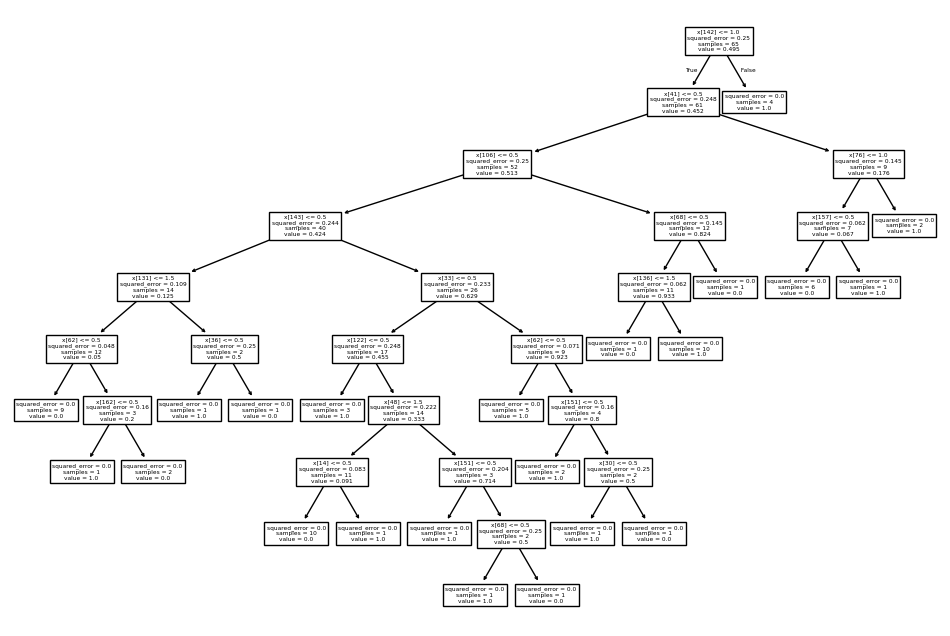

In [34]:
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse_train = mean_squared_error(rf_model.predict(X_train), y_train)
mse_test = mean_squared_error(y_test, y_pred)

print(f"Train Accuracy: {1-mse_train}")
print(f"Test Accuracy: {1-mse_test}")

tree = rf_model.estimators_[0]

plt.figure(figsize = (12, 8))
plot_tree(tree)
plt.show()

While this model achieved the most satisfactory accuracy results, it is much harder to interpret and basically unusable in the context of the question I want to answer.